# Info
Name:  

    Gas_sepctra_insformation_content
    
Purpose:  

    Loads HiTRAN for NO2 and Ozone, and uses different fwhm to subsample and calculate the information content
    Adds random noise to sampling
  
Input:

    None
  
Output:

    figures and save files...
  
Keywords:

    none
  
Dependencies:

    - load_utils.py : for loading OMI HDF5 files
    - matplotlib
    - numpy
  
Needed Files:

  - file.rc : for consistent creation of look of matplotlib figures
  - 
  
Modification History:

    Written: Samuel LeBlanc, Santa Cruz, CA, 2019-06-14
    Modified: 

# Prepare python environment

In [179]:
%config InlineBackend.rc = {}
import matplotlib 
import os
matplotlib.rc_file(os.path.join(os.getcwd(),'file.rc'))
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import Sp_parameters as Sp
from load_utils import mat2py_time, toutc, load_ict
import load_utils as lu
import plotting_utils as pu
from path_utils import getpath
import hdf5storage as hs
from datetime import datetime
from scipy.interpolate import UnivariateSpline,interp1d
import matplotlib.dates as mdates
from mpl_toolkits.basemap import Basemap
import scipy.stats as st
from scipy import integrate

In [2]:
import hapi

HAPI version: 1.1.0.9.6
To get the most up-to-date version please check http://hitran.org/hapi
ATTENTION: Python versions of partition sums from TIPS-2017 are now available in HAPI code

           It is free to use HAPI. If you use HAPI in your research or software development,
           please cite it using the following reference:
           R.V. Kochanov, I.E. Gordon, L.S. Rothman, P. Wcislo, C. Hill, J.S. Wilzewski,
           HITRAN Application Programming Interface (HAPI): A comprehensive approach
           to working with spectroscopic data, J. Quant. Spectrosc. Radiat. Transfer 177, 15-30 (2016)
           DOI: 10.1016/j.jqsrt.2016.03.005


In [3]:
%matplotlib notebook

In [7]:
fp =getpath('4STAR_gas')

Return path named:  4STAR_gas /data/sam/4STAR/gas/


# Load files for NO2

## Using the HAPI hitran python API

In [8]:
hapi.getHelp('tutorial')

-----------------------------------
This is a tutorial section of help.
-----------------------------------
Please choose the subject of tutorial:
    data      -  downloading the data and working with it
    spectra   -  calculating spectral functions
    plotting  -  visualizing data with matplotlib
    python    -  Python quick start guide


In [9]:
hapi.getHelp('data')



ACCESS YOUR DATA!

Welcome to tutorial on retrieving and processing the data from HITRANonline.


  ///////////////
 /// PREFACE ///
///////////////

HITRANonline API is a set of routines in Python which is aimed to 
provide a remote access to functionality and data given by a new project 
HITRANonline (http://hitranazure.cloudapp.net).

At the present moment the API can download, filter and process data on 
molecular and atomic line-by-line spectra which is provided by HITRANonline portal.

One of the major purposes of introducing API is extending a functionality 
of the main site, particularly providing a possibility to calculate several 
types of high- and low-resolution spectra based on a flexible HT lineshape. 

Each feature of API is represented by a Python function with a set of parameters 
providing a flexible approach to the task.


  ///////////////////////
 /// FEATURE SUMMARY ///
///////////////////////

1) Downloading line-by-line data from the HITRANonline site to local

In [10]:
hapi.db_begin('data')

Using data



In [11]:
hapi.getHelp(hapi.fetch)

Help on function fetch in module hapi:

fetch(TableName, M, I, numin, numax, ParameterGroups=[], Parameters=[])
    INPUT PARAMETERS: 
        TableName:   local table name to fetch in (required)
        M:           HITRAN molecule number       (required)
        I:           HITRAN isotopologue number   (required)
        numin:       lower wavenumber bound       (required)
        numax:       upper wavenumber bound       (required)
    OUTPUT PARAMETERS: 
        none
    ---
    DESCRIPTION:
        Download line-by-line data from HITRANonline server
        and save it to local table. The input parameters M and I
        are the HITRAN molecule and isotopologue numbers.
        This function results in a table containing single 
        isotopologue specie. To have multiple species in a 
        single table use fetch_by_ids instead.
    ---
    EXAMPLE OF USAGE:
        fetch('HOH',1,1,4000,4100)
    ---



In [12]:
hapi.fetch('NO2',0,1,29164,40798)

KeyError: (0, 1)

## Load the crosssection files directly

In [13]:
no2_xsc = []
len(no2_xsc)

0

In [14]:
fname = fp+'no2/NO2_294.0_0.0_15002.0-42002.3_00.xsc'

In [15]:
def read_xsc(fname):
    'Reading function for xsc files. full file path at fname, returns dict with numpy'
    import numpy as np
    no2_xsc = []
    no2h = []
    with open(fname) as f:
        if len(no2_xsc) < 1:
            no2h = f.readline()
        l = f.readlines()
        l = [tl[:-1] for tl in l]
        ''.join(l).strip().split(' ')
        no2_xsc = np.array([float(g) for g in ''.join(l).strip().split(' ')])
    header = {'molecule':no2h[0:20].strip(),'wvn_min':float(no2h[20:30]),'wvn_max':float(no2h[30:40]),'N':int(no2h[40:47]),
              'T':float(no2h[47:54]),'P':float(no2h[54:60]),'max_xsc':float(no2h[60:70]),'resolution':float(no2h[70:75]),
              'name':no2h[75:90].strip(),'na':no2h[90:94],'broadener':no2h[94:97].strip(),'ref':int(no2h[97:100]),
              'xsc':no2_xsc}
    header['wv'] = np.linspace(header['wvn_min'],header['wvn_max'],header['N'])
    header['nm'] = 1.0/header['wv'] *10.0*1000.0*1000.0
    return header


In [16]:
no2 = read_xsc(fp+'no2/NO2_294.0_0.0_15002.0-42002.3_00.xsc')

In [17]:
no2

{'N': 27993,
 'P': 0.0,
 'T': 294.0,
 'broadener': 'air',
 'max_xsc': 8.395e-19,
 'molecule': 'NO2',
 'na': '    ',
 'name': 'NO2',
 'nm': array([666.57810066, 666.53524492, 666.49239469, ..., 238.09312442,
        238.08765655, 238.08218892]),
 'ref': 17,
 'resolution': 2.0,
 'wv': array([15001.993     , 15002.95757234, 15003.92214468, ...,
        42000.37285532, 42001.33742766, 42002.302     ]),
 'wvn_max': 42002.302,
 'wvn_min': 15001.993,
 'xsc': array([8.821e-21, 8.778e-21, 8.149e-21, ..., 9.242e-20, 1.248e-19,
        7.288e-20])}

<IPython.core.display.Javascript object>


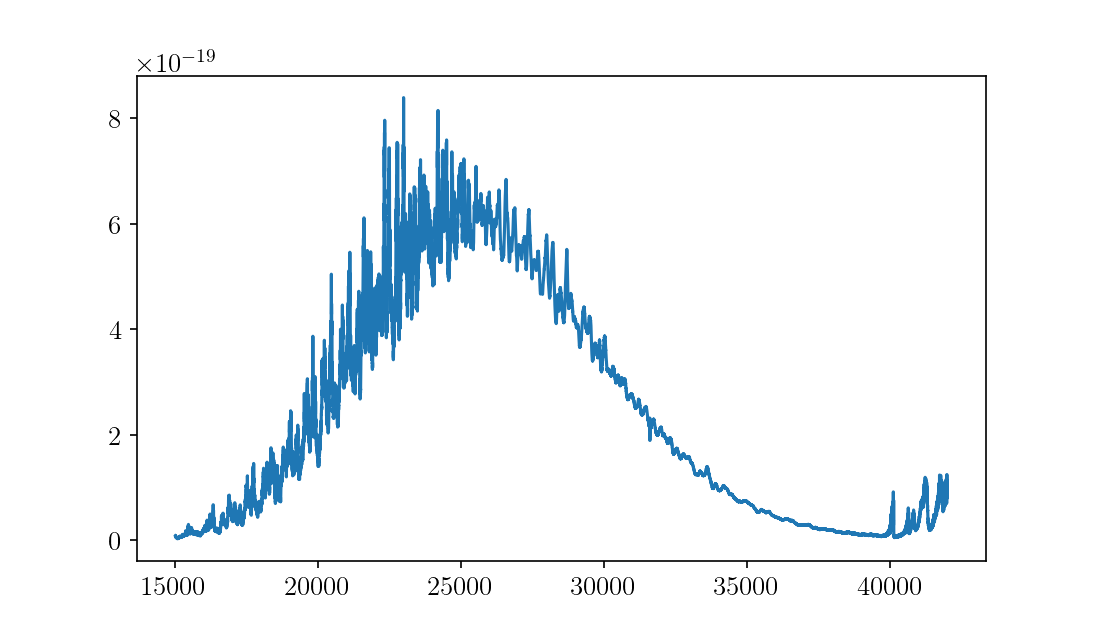

In [18]:
plt.figure()
plt.plot(no2['wv'],no2['xsc'])

<IPython.core.display.Javascript object>


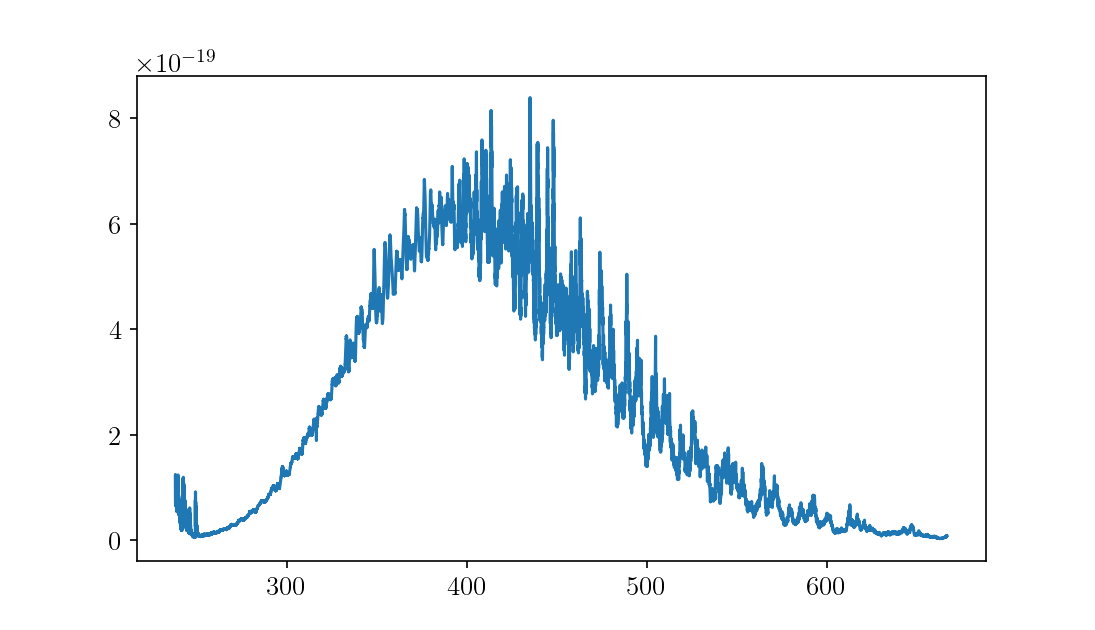

In [19]:
plt.figure()
plt.plot(no2['nm'],no2['xsc'])

## Count the peaks

In [20]:
import scipy.signal as sig

In [76]:
no2['nm'][10360]

400.08061681828275

In [77]:
ip = sig.find_peaks(no2['xsc'],width=7,prominence=0.005*no2['xsc'][10360])[0]

In [78]:
len(ip)

221

<IPython.core.display.Javascript object>


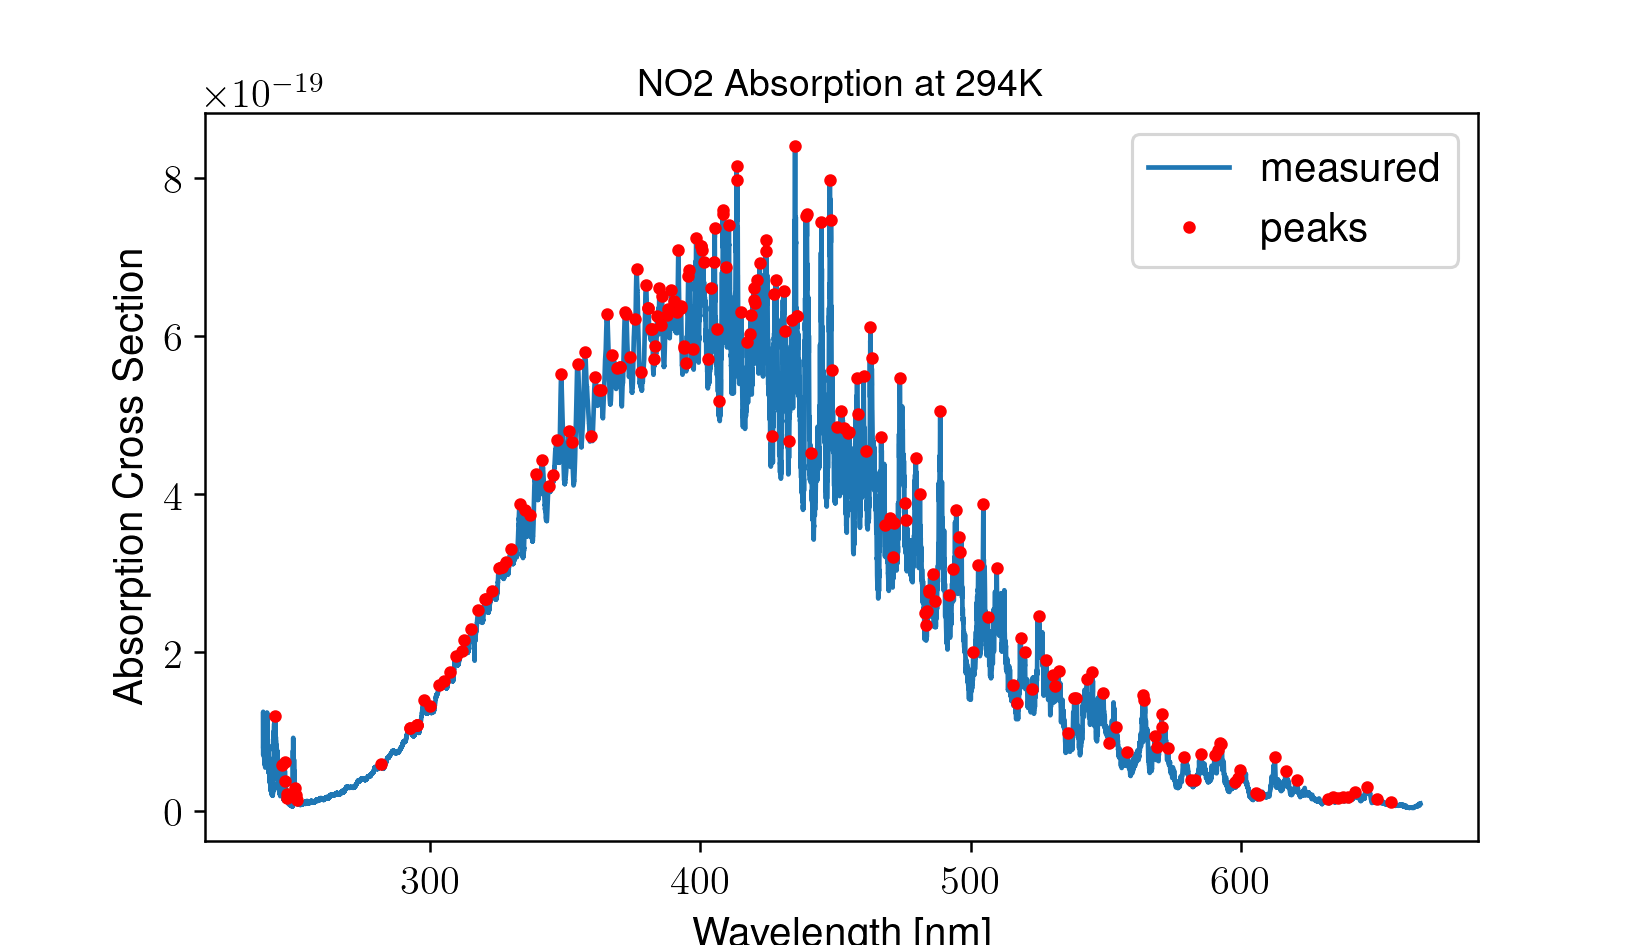

Text(0.5,1,'NO2 Absorption at 294K')

In [290]:
plt.figure()
plt.plot(no2['nm'],no2['xsc'],label='measured')
plt.plot(no2['nm'][ip],no2['xsc'][ip],'.r',label='peaks')
plt.legend()
plt.xlabel('Wavelength [nm]')
plt.ylabel('Absorption Cross Section')
plt.title('NO2 Absorption at 294K')


## Make the Shannon information content function

In [99]:
def sic(p):
    'Shannon Information of probability distribution p'
    n = len(p)
    pd = p / np.sum(p)
    sic = np.nansum(pd*np.log2(pd)) * (-1.0)
    return sic

In [100]:
no2s = sic(no2['xsc'])

In [101]:
no2s

14.144229792013222


## Build the gaussian smoothing slit functions

In [50]:
def gaussian( x, u , s):
    return 1./np.sqrt( 2. * np.pi * s**2 ) * np.exp(-1.0/2.0*((x-u)/s)**2.0)


<IPython.core.display.Javascript object>


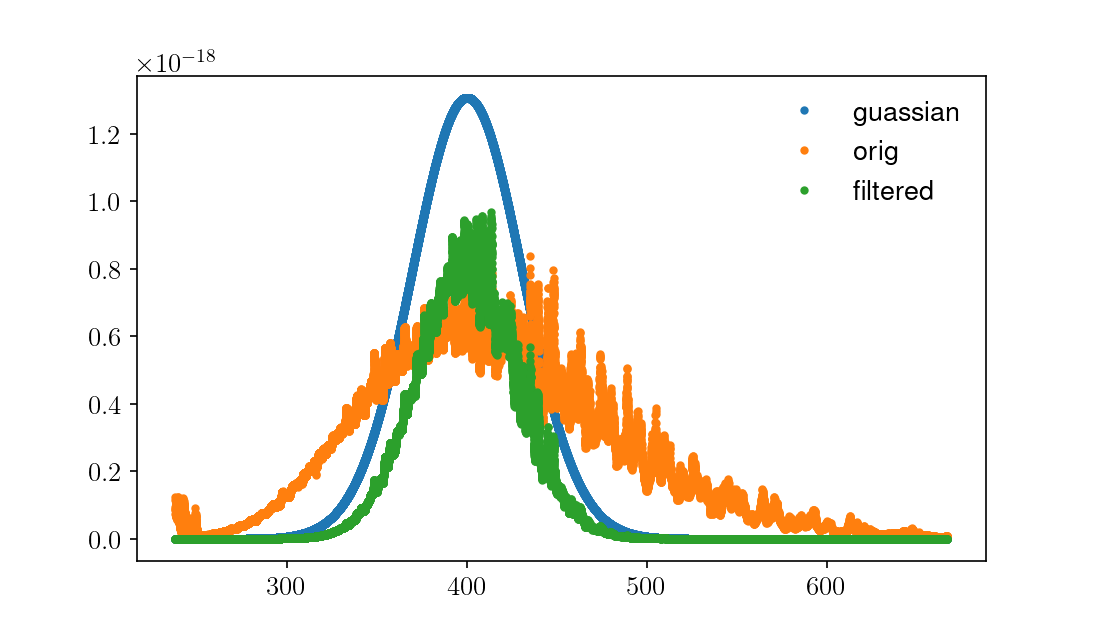

In [51]:
plt.figure()
plt.plot(no2['nm'],gaussian(no2['nm'],400.0,30.5)*0.0000000000000001,'.',label='guassian')
plt.plot(no2['nm'],no2['xsc'],'.',label='orig')
plt.plot(no2['nm'],gaussian(no2['nm'],400.0,30.5)*no2['xsc']*100.0,'.',label='filtered')
plt.legend(frameon=False)

In [52]:
integrate.simps(gaussian(no2['nm'],400.0,30.5),no2['nm'])

-0.9999999448194865

In [53]:
integrate.simps(gaussian(no2['nm'],400.0,30.5)*no2['xsc'],no2['nm'])

-5.62332662999015e-19

In [54]:
i4 = np.argmin(abs(no2['nm']-400.0))
no2['xsc'][i4],no2['nm'][i4]

(6.989e-19, 400.00343481600504)

In [95]:
len(np.diff(no2['nm']))

27992

In [88]:
integrate.simps(gaussian(no2['nm'],400.0,0.1),no2['nm'])

-0.9999999999999989

## Run through and convolve gaussian with cross sections

In [139]:
fwhms = np.around(np.logspace(-1,0.75,40),2)

In [140]:
fwhms

array([0.1 , 0.11, 0.12, 0.14, 0.15, 0.17, 0.19, 0.21, 0.23, 0.25, 0.28,
       0.31, 0.35, 0.38, 0.42, 0.47, 0.52, 0.58, 0.64, 0.71, 0.79, 0.88,
       0.97, 1.08, 1.19, 1.32, 1.47, 1.63, 1.8 , 2.  , 2.22, 2.46, 2.73,
       3.03, 3.35, 3.72, 4.12, 4.57, 5.07, 5.62])

In [141]:
nns = np.array([sig.convolve(no2['xsc'],gaussian(np.arange(0,400,0.1),200,fw),mode='same')*0.1 for fw in fwhms])

In [142]:
nns.shape

(40, 27993)

In [143]:
from mpltools import color

<IPython.core.display.Javascript object>


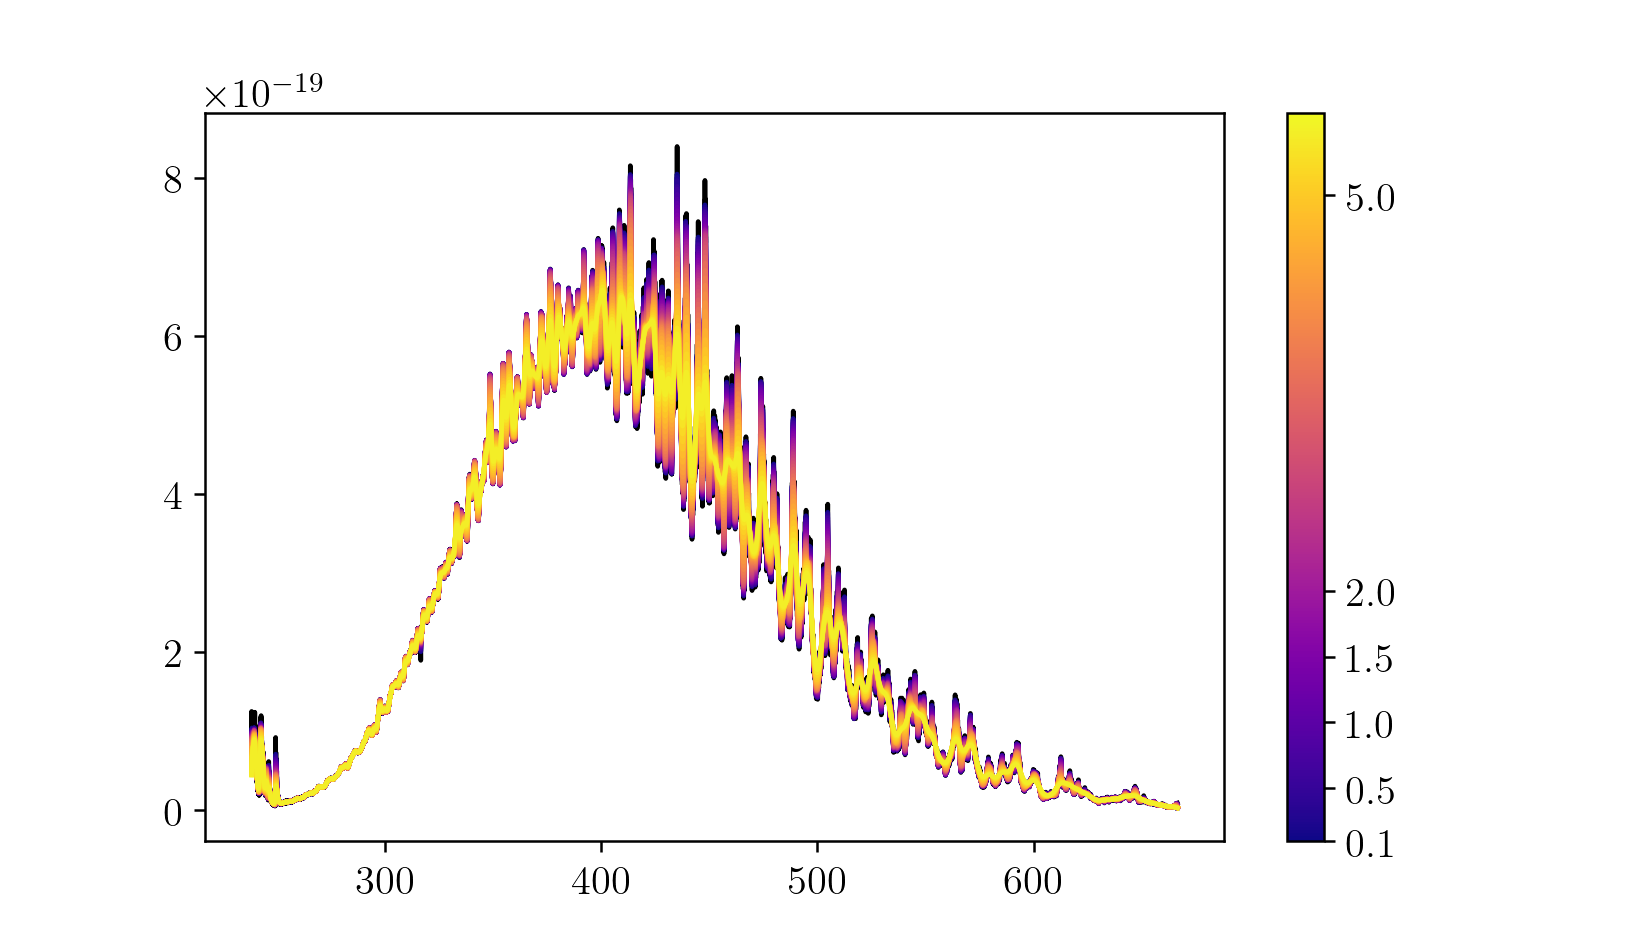

/home/sam/.local/lib/python2.7/site-packages/mpltools/color.py:217: MatplotlibDeprecationWarning: The set_color_cycle function was deprecated in version 1.5. Use `.set_prop_cycle` instead.
  ax.set_color_cycle(color_cycle)


In [291]:
plt.figure()
plt.plot(no2['nm'],no2['xsc'],label='og',color='k')
cmap = 'plasma'
color.cycle_cmap(length=len(fwhms)+1,cmap=cmap,ax=plt.gca())
for i,fw in enumerate(fwhms):
    plt.plot(no2['nm'],nns[i,:],label='conv: fwhm {}'.format(fw))
scalarmap = plt.cm.ScalarMappable(cmap=plt.cm.get_cmap(cmap))
scalarmap.set_array(fwhms)
plt.colorbar(scalarmap,ticks=[0.1,0.5,1.0,1.5,2.0,5.0])

In [148]:
scalarmap.autoscale_None()

### Get the number of peaks for full distribution

In [168]:
peaks = [len(sig.find_peaks(nx,prominence=0.005*no2['xsc'][10360])[0]) for nx in nns] # for 0.5% in tranmistance giving ~0.005 OD   

In [157]:
no2['nm'][-1]

238.08218892383562

In [171]:
import matplotlib.ticker as mti

<IPython.core.display.Javascript object>


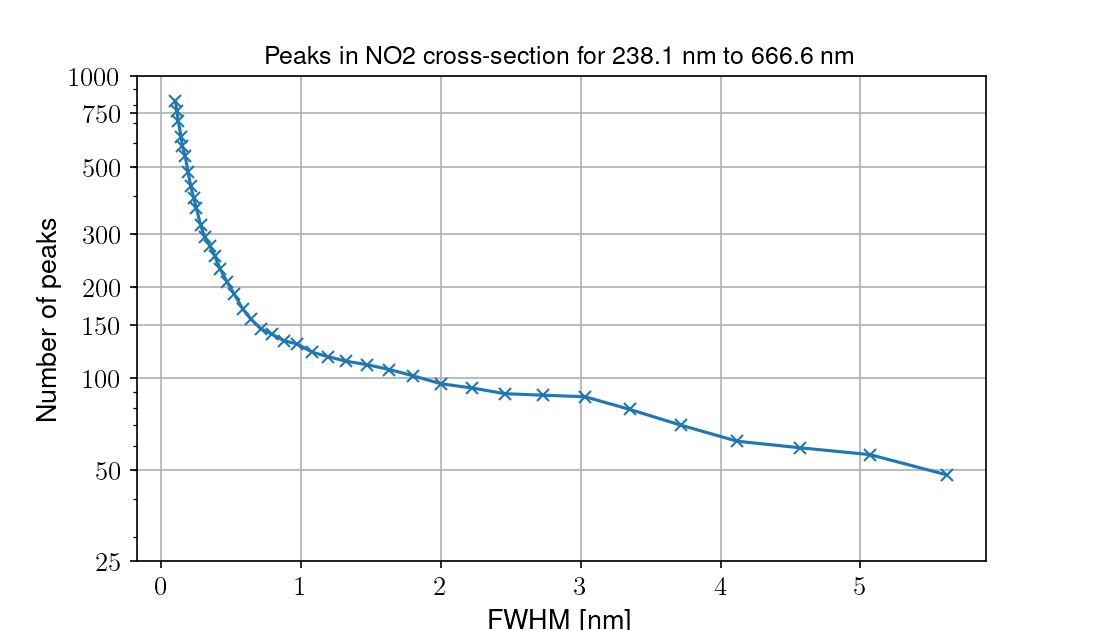

Text(0.5,1,'Peaks in NO2 cross-section for 238.1 nm to 666.6 nm')

In [172]:
plt.figure()
plt.plot(fwhms,peaks,'x-')
plt.yscale('log')
plt.yticks([25,50,100,150,200,300,500,750,1000])
plt.gca().get_yaxis().set_major_formatter(mti.ScalarFormatter())
plt.grid()
plt.xlabel('FWHM [nm]')
plt.ylabel('Number of peaks')
plt.title('Peaks in NO2 cross-section for {:3.1f} nm to {:3.1f} nm'.format(no2['nm'][-1],no2['nm'][0]))

### Get the number of peaks for 4STAR retrieval [460 nm - 490 nm]

In [167]:
nm_rt = (no2['nm']>460.0) & (no2['nm']<490.0) 

In [169]:
peaks_rt = [len(sig.find_peaks(nx[nm_rt],prominence=0.005*no2['xsc'][10360])[0]) for nx in nns]

<IPython.core.display.Javascript object>


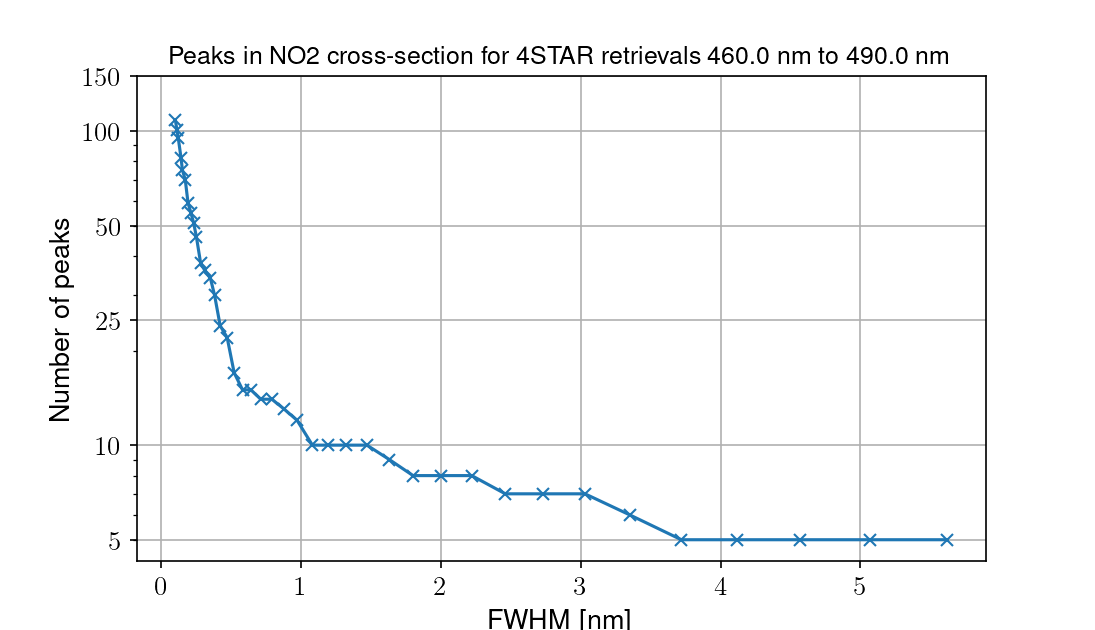

Text(0.5,1,'Peaks in NO2 cross-section for 4STAR retrievals 460.0 nm to 490.0 nm')

In [178]:
plt.figure()
plt.plot(fwhms,peaks_rt,'x-')
plt.yscale('log')
plt.yticks([5,10,25,50,100,150])
plt.gca().get_yaxis().set_major_formatter(mti.ScalarFormatter())
plt.grid()
plt.xlabel('FWHM [nm]')
plt.ylabel('Number of peaks')
plt.title('Peaks in NO2 cross-section for 4STAR retrievals {:3.1f} nm to {:3.1f} nm'.format(no2['nm'][nm_rt][-1],no2['nm'][nm_rt][0]))

### Now subset for changing sampling values

In [196]:
dsp = np.arange(0.1,3.2,0.2)

In [197]:
dsp

array([0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9, 2.1, 2.3, 2.5,
       2.7, 2.9, 3.1])

In [198]:
np.arange(460,490+dsp[5],dsp[5])

array([460. , 461.1, 462.2, 463.3, 464.4, 465.5, 466.6, 467.7, 468.8,
       469.9, 471. , 472.1, 473.2, 474.3, 475.4, 476.5, 477.6, 478.7,
       479.8, 480.9, 482. , 483.1, 484.2, 485.3, 486.4, 487.5, 488.6,
       489.7, 490.8])

In [276]:
peaks_d = np.zeros((len(nns[:,0]),len(dsp)))+np.nan
peaks_d2 = np.zeros((len(nns[:,0]),len(dsp)))+np.nan
peaks_d3 = np.zeros((len(nns[:,0]),len(dsp)))+np.nan

for ni,nx in enumerate(nns):
    for di, d in enumerate(dsp):
        fsp = interp1d(no2['nm'][nm_rt],nx[nm_rt],fill_value='extrapolate')
        nxd = fsp(np.arange(460.0,490.0,d))
        peaks_d[ni,di] = len(sig.find_peaks(nxd,prominence=0.005*no2['xsc'][10360])[0])
        peaks_d2[ni,di] = len(sig.find_peaks(nxd,prominence=0.01*no2['xsc'][10360])[0])
        peaks_d3[ni,di] = len(sig.find_peaks(nxd,prominence=0.02*no2['xsc'][10360])[0])

In [209]:
peaks_d.shape

(40, 16)

<IPython.core.display.Javascript object>


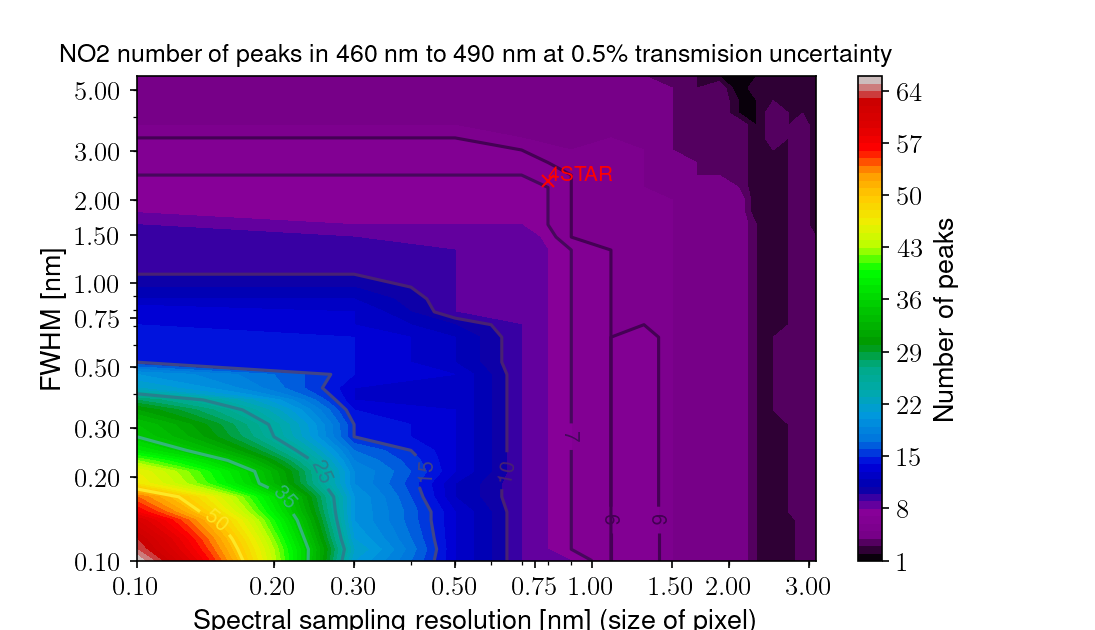

/home/sam/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/sam/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/sam/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/sam/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/sam/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans

/home/sam/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/sam/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/sam/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/sam/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/sam/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans

In [286]:
plt.figure()
plt.contourf(dsp, fwhms,peaks_d,66,cmap='nipy_spectral')
plt.yscale('log')
plt.xscale('log')
plt.yticks([0.1,0.2,0.3,0.5,0.75,1.0,1.5,2.0,3.0,5.0])
plt.xticks([0.1,0.2,0.3,0.5,0.75,1.0,1.5,2.0,3.0])
plt.gca().get_yaxis().set_major_formatter(mti.ScalarFormatter())
plt.gca().get_xaxis().set_major_formatter(mti.ScalarFormatter())
plt.xlabel('Spectral sampling resolution [nm] (size of pixel)')
plt.ylabel('FWHM [nm]')
plt.title('NO2 number of peaks in 460 nm to 490 nm  at 0.5\% transmision uncertainty')
plt.colorbar(label='Number of peaks')
plt.plot(0.8,2.34,'rx')
plt.annotate('4STAR',(0.8,2.34),color='r')


cs = plt.contour(dsp, fwhms,peaks_d,[6,7,10,15,25,35,50])
ac = plt.gca()
ac.clabel(cs,inline=1, fontsize=10,fmt='%2.0f')

plt.savefig(fp+'NO2_peaks_per_FWHM_and_sampling_log_unc05.png',dpi=600,transparent=True)

<IPython.core.display.Javascript object>


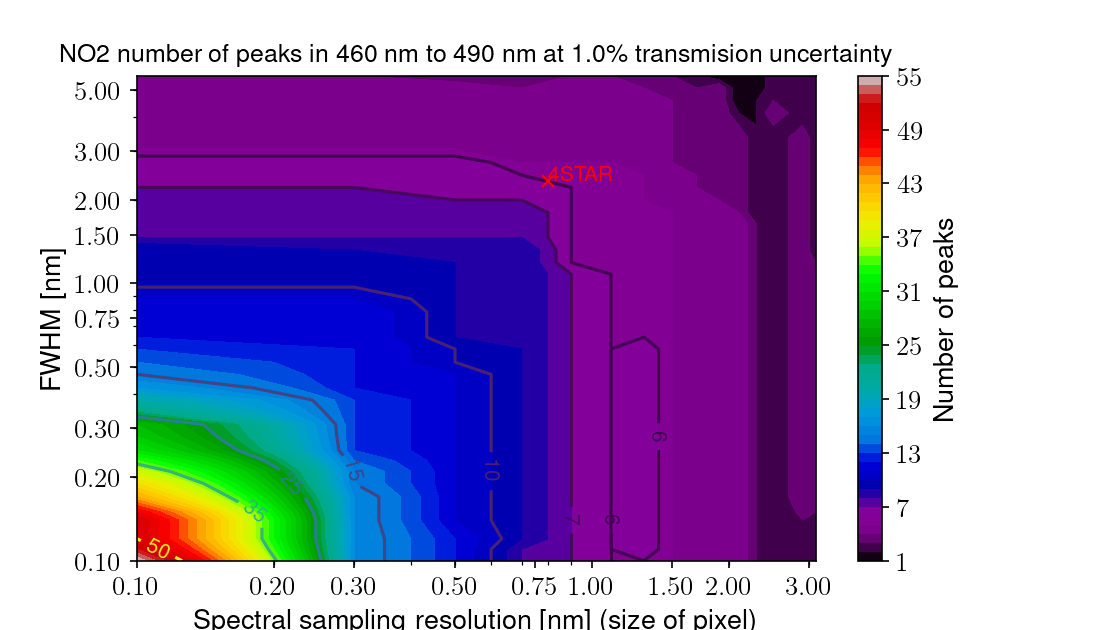

/home/sam/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/sam/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/sam/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/sam/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/sam/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans

/home/sam/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/sam/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/sam/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/sam/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/sam/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans

In [287]:
plt.figure()
plt.contourf(dsp, fwhms,peaks_d2,66,cmap='nipy_spectral')
plt.yscale('log')
plt.xscale('log')
plt.yticks([0.1,0.2,0.3,0.5,0.75,1.0,1.5,2.0,3.0,5.0])
plt.xticks([0.1,0.2,0.3,0.5,0.75,1.0,1.5,2.0,3.0])
plt.gca().get_yaxis().set_major_formatter(mti.ScalarFormatter())
plt.gca().get_xaxis().set_major_formatter(mti.ScalarFormatter())
plt.xlabel('Spectral sampling resolution [nm] (size of pixel)')
plt.ylabel('FWHM [nm]')
plt.title('NO2 number of peaks in 460 nm to 490 nm at 1.0\% transmision uncertainty')
plt.colorbar(label='Number of peaks')
plt.plot(0.8,2.34,'rx')
plt.annotate('4STAR',(0.8,2.34),color='r')


cs = plt.contour(dsp, fwhms,peaks_d2,[6,7,10,15,25,35,50])
ac = plt.gca()
ac.clabel(cs,inline=1, fontsize=10,fmt='%2.0f')
plt.savefig(fp+'NO2_peaks_per_FWHM_and_sampling_log_unc10.png',dpi=600,transparent=True)

<IPython.core.display.Javascript object>


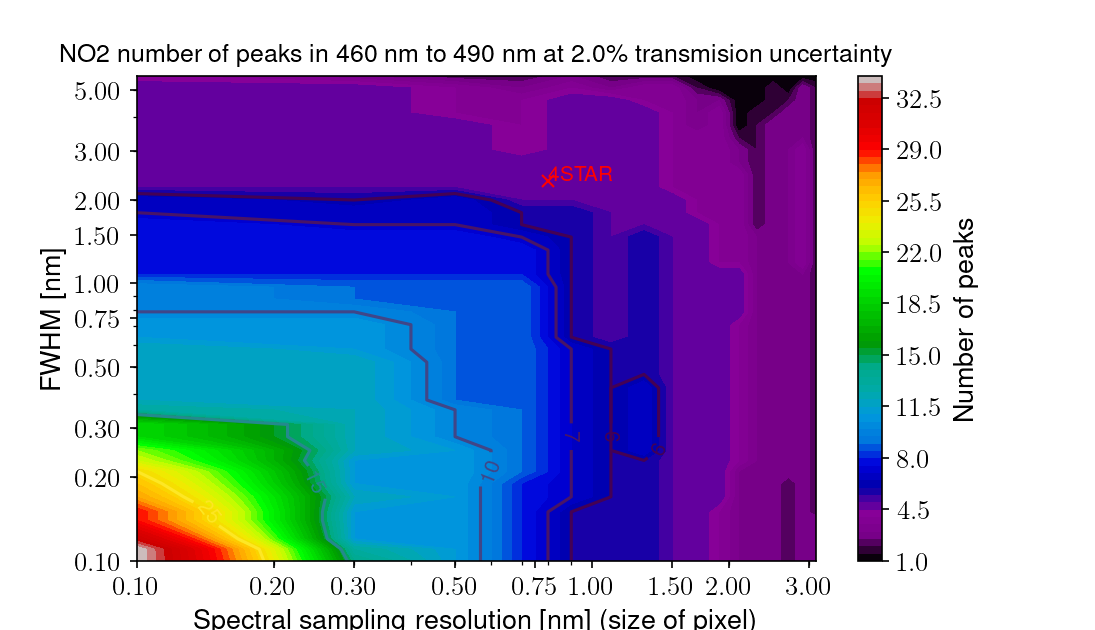

/home/sam/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/sam/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/sam/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/sam/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/sam/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans

/home/sam/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/sam/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/sam/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/sam/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/sam/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans

In [288]:
plt.figure()
plt.contourf(dsp, fwhms,peaks_d3,66,cmap='nipy_spectral')
plt.yscale('log')
plt.xscale('log')
plt.yticks([0.1,0.2,0.3,0.5,0.75,1.0,1.5,2.0,3.0,5.0])
plt.xticks([0.1,0.2,0.3,0.5,0.75,1.0,1.5,2.0,3.0])
plt.gca().get_yaxis().set_major_formatter(mti.ScalarFormatter())
plt.gca().get_xaxis().set_major_formatter(mti.ScalarFormatter())
plt.xlabel('Spectral sampling resolution [nm] (size of pixel)')
plt.ylabel('FWHM [nm]')
plt.title('NO2 number of peaks in 460 nm to 490 nm at 2.0\% transmision uncertainty')
plt.colorbar(label='Number of peaks')
plt.plot(0.8,2.34,'rx')
plt.annotate('4STAR',(0.8,2.34),color='r')


cs = plt.contour(dsp, fwhms,peaks_d3,[6,7,10,15,25,35,50])
ac = plt.gca()
ac.clabel(cs,inline=1, fontsize=10,fmt='%2.0f')
plt.savefig(fp+'NO2_peaks_per_FWHM_and_sampling_log_unc20.png',dpi=600,transparent=True)

<IPython.core.display.Javascript object>


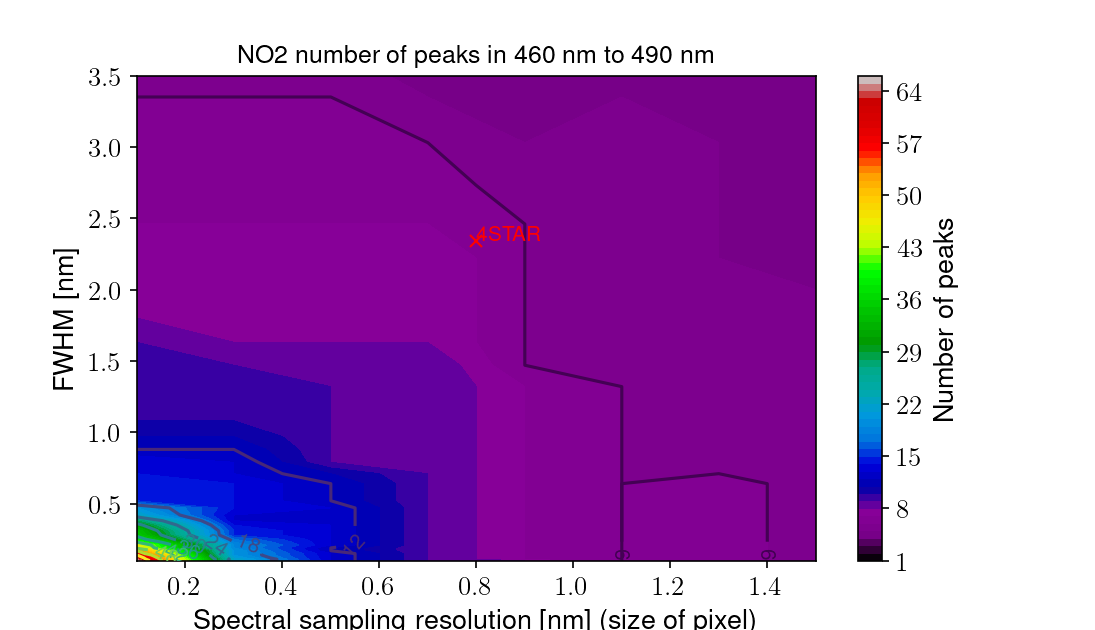

/home/sam/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/sam/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/sam/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/sam/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/sam/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans

/home/sam/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/sam/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/sam/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/sam/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/sam/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans

In [262]:
plt.figure()
plt.contourf(dsp, fwhms,peaks_d,66,cmap='nipy_spectral')

#plt.yticks([0.1,0.2,0.3,0.5,0.75,1.0,1.5,2.0,3.0,5.0])
#plt.xticks([0.1,0.2,0.3,0.5,0.75,1.0,1.5,2.0,3.0])
#plt.gca().get_yaxis().set_major_formatter(mti.ScalarFormatter())
#plt.gca().get_xaxis().set_major_formatter(mti.ScalarFormatter())
plt.xlim(0.1,1.5)
plt.ylim(0.1,3.5)
plt.xlabel('Spectral sampling resolution [nm] (size of pixel)')
plt.ylabel('FWHM [nm]')
plt.title('NO2 number of peaks in 460 nm to 490 nm')
plt.colorbar(label='Number of peaks')
plt.plot(0.8,2.34,'rx')
plt.annotate('4STAR',(0.8,2.34),color='r')


cs = plt.contour(dsp, fwhms,peaks_d,10)
ac = plt.gca()
ac.clabel(cs,inline=1, fontsize=10,fmt='%2.0f')
plt.savefig(fp+'NO2_peaks_per_FWHM_and_sampling.png',dpi=600,transparent=True)

## Old method

In [55]:
def convolver(xsc,nm,fwhm):
    'function to go through the cross-section (xsc) and convolve a gaussian with full-width-half-max (fwhm), at the sampling grid (nm)'
    from scipy import integrate
    import numpy as np
    return np.array([integrate.simps(gaussian(nm,n,fwhm)*xsc,nm)*-1.0 for n in nm])

        
    

<IPython.core.display.Javascript object>


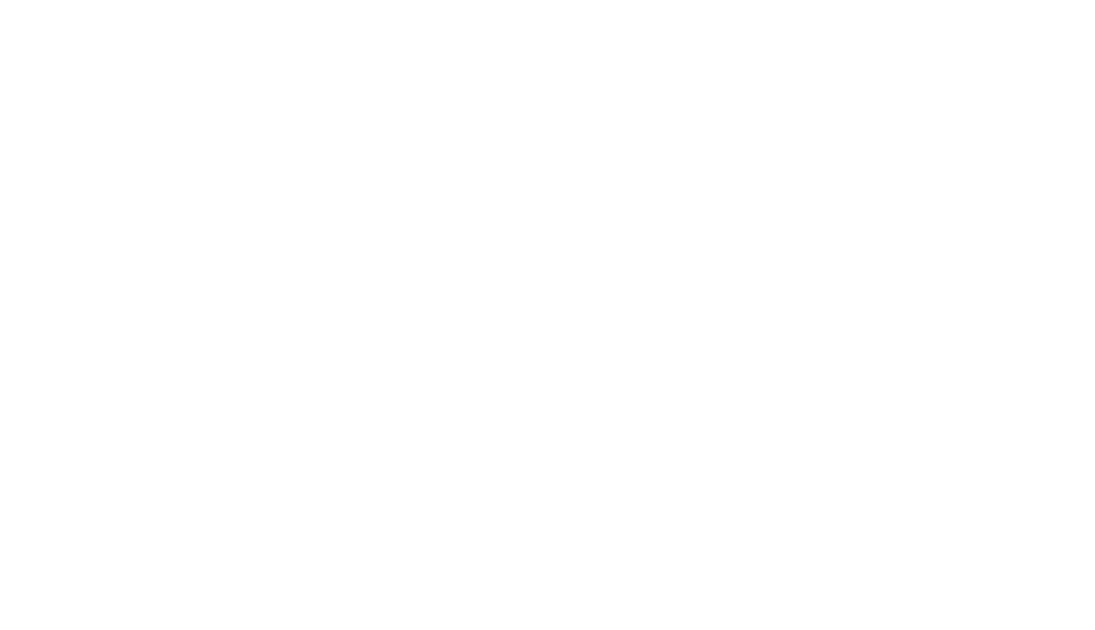

KeyboardInterrupt: 

In [56]:
plt.figure()
plt.plot(no2['nm'],no2['xsc'],'.',label='orig')
plt.plot(no2['nm'],convolver(no2['xsc'],no2['nm'],0.2),label='FWHM 0.2 nm')
plt.plot(no2['nm'],convolver(no2['xsc'],no2['nm'],0.4),label='FWHM 0.4 nm')
plt.plot(no2['nm'],convolver(no2['xsc'],no2['nm'],0.6),label='FWHM 0.6 nm')
plt.plot(no2['nm'],convolver(no2['xsc'],no2['nm'],0.8),label='FWHM 0.8 nm')
plt.plot(no2['nm'],convolver(no2['xsc'],no2['nm'],1.2),label='FWHM 1.2 nm')
plt.plot(no2['nm'],convolver(no2['xsc'],no2['nm'],1.5),label='FWHM 1.5 nm')
plt.plot(no2['nm'],convolver(no2['xsc'],no2['nm'],2.0),label='FWHM 2.0 nm')
plt.legend(frameon=False)

In [123]:
fwhms = np.around(np.logspace(-1,0.75,20),2)

In [124]:
fwhms

array([0.1 , 0.12, 0.15, 0.19, 0.23, 0.29, 0.36, 0.44, 0.55, 0.67, 0.83,
       1.03, 1.27, 1.58, 1.95, 2.41, 2.98, 3.68, 4.55, 5.62])

In [80]:
convolver(no2['xsc'],no2['nm'],0.1)

array([4.19878111e-21, 5.51572804e-21, 6.54687265e-21, ...,
       5.01123199e-20, 4.81495172e-20, 4.61780283e-20])

In [59]:
subsamp = [convolver(no2['xsc'],no2['nm'],fw) for fw in fwhms]    

KeyboardInterrupt: 

In [ ]:
sub_sic = [sic(s) for s in subsamp]

<IPython.core.display.Javascript object>


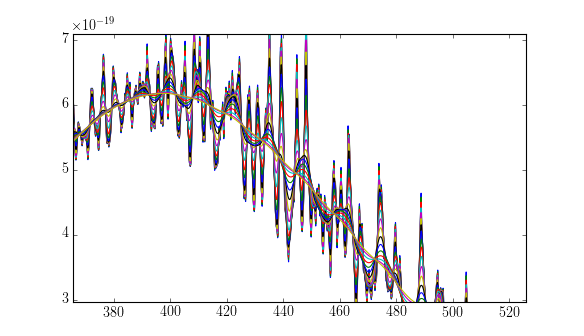

In [161]:
plt.figure()
plt.plot(no2['nm'],np.array(subsamp).T)

<IPython.core.display.Javascript object>


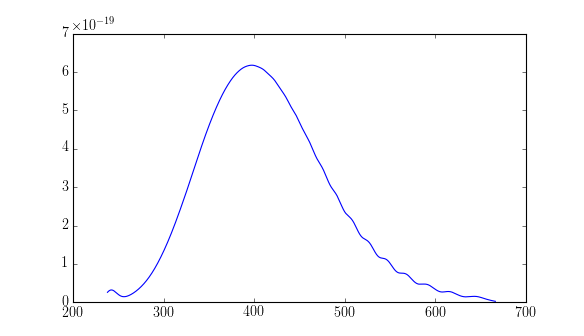

(14.155148286984438, 14.144229792013222)

In [165]:
plt.figure() 
plt.plot(no2['nm'],subsamp[-1])
sic(subsamp[-1]),sic(no2['xsc'])

<IPython.core.display.Javascript object>


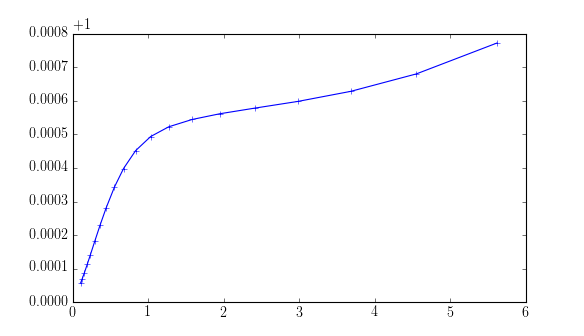

In [159]:
plt.figure()
plt.plot(fwhms, sub_sic/sic(no2['xsc']),'+-')

In [157]:
sic(no2['xsc'])

14.144229792013222

In [156]:
sic(gaussian(no2['nm'],400.0,2.0))

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log2
  """
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in multiply
  """


9.06513495417367

## Add some white noise

In [135]:
snr = 1.0/1000.0
np.random.rand(len(no2['nm']))*no2['max_xsc']*snr

array([5.33208870e-22, 6.39391580e-22, 6.86646447e-22, ...,
       6.39660230e-22, 3.78466762e-22, 2.17066359e-22])

# Load files for SO2

## Load the crossections

In [ ]:
fnameso2 = fp+'Sulfur_Dioxide/SO2_298.1K-760.0Torr_500.0-6500.0_0.11_N2_618_43.txt'

In [ ]:
so2 = read_xsc(fp+'no2/NO2_294.0_0.0_15002.0-42002.3_00.xsc')

# Plotting
Present some fo the early plots here